# Creating your project and comparing historical meteorological datasets

## Introduction

Notebook for the workflow **Snakefile_climate_historical**: 
1. extract climatic data for each climate source for the selected region and write to netcdf, 
2. plot annual gridded anomalies for temperature and precipitation for each climate source, 
3. sample point locations of precipitation and temperature at meteorological station observations (if available) and sample areal precipitation and temperature over subregions for each climate source, 
4. derive historical trends in precipitation and temperature for each climate source,
5. plot precipitation and temperature characteristics for each climate source,
6. plot region, elevation and meteorological stations (if available).

In [1]:
# Import some python libraries we will need to run this notebook
import os
import pandas as pd
from IPython import display

In [2]:
# A helper function
from subprocess import Popen, PIPE, STDOUT

from IPython.core.magic import register_line_magic


@register_line_magic
def runrealcmd(command):
    with Popen(
        command, stdout=PIPE, shell=True, stderr=STDOUT, bufsize=1, close_fds=True
    ) as process:
        for line in iter(process.stdout.readline, b""):
            print(line.rstrip().decode("utf-8"))

## Defining your project region and properties

First thing is to prepare all the options for your project, this is done using the configuration or settings file below

In [3]:
# Add here the path where you have installed the blueearth-cst tool
cst_path = r'c:\Users\bouaziz\repos\blueearth_cst'
os.chdir(cst_path)

To extract data for your basin or region of interest, you will need to provide:

- for a basin to the sea, any point in the basin [x, y]
- for a subbasin (tributary or part of a basin) the location of the subbasin outlet [xout, yout]
- a bounding box [xmin, ymin, xmax, ymax]
- a geometry file of your region of interest (e.g., myregion.shp)

For more details on the exact syntax, please have a look at:
https://deltares.github.io/hydromt/stable/user_guide/model_region.html#hydrographic-region 

The coordinates should be in EPSG 4326.
For points, you can use Google Maps to locate your coordinates.
For bounding box or point coordinates, you can also copy-paste locations from this website: http://bboxfinder.com/

In [4]:
%%writefile ./config/my-project-settings.yml

########################################################################################
#################################### General settings ##################################

# Path to where the wflow model will be stored (include the project name)
project_dir: examples/myModel

# hydromt "region" for building the model, coordinates are in EPSG 4326
# for more info on how to fill this, please check the hydromt documentation: 
# https://deltares.github.io/hydromt/stable/user_guide/model_region.html#hydrographic-region 
# For wflow please use either 'basin' or 'subbasin' keywords
model_region: "{'subbasin': [12.3758, 46.4076], 'uparea': 70}"

# Path to the data catalog to use (can be different for Linux/Windows/data stored on P drive or other)
# NB: should in order of priority! 
data_sources: 
  - artifact_data
  - tests/data/tests_data_catalog.yml

# Info on the historical climate data is used in the historic model run + reference data for the weather generator
# Time horizon of the historical period
starttime: "2000-01-01T00:00:00"
endtime: "2010-12-31T00:00:00"

# Historical gridded climate data sources (name as available in the data_sources catalog file). 
clim_historical: 
  - era5
  - chirps_global

#colors to use for plotting (same order as provided in clim_historical)
clim_historical_colors:
  - blue
  - green

########################################################################################
######################### Analysis of historical climate data ##########################

# Buffer in km to apply to the region for the climate analysis
region_buffer: 10
# Hydrography dataset to use to derive region from (sub)basin
hydrography_fn: merit_hydro_1k
# River geometry dataset to add to plots
river_geom_fn: river_atlas

# Additional sub-basins or sub-regions to include in the analysis
climate_subregions: "tests/test_project/hydrology_model/staticgeoms/subcatch_discharge-locations-grdc.geojson"

# If available, please put here the path to the available climate observation stations locations files
# csv file containing four columns: station_ID, name, x, y
climate_locations: "tests/data/observations/climate-locations-eca.csv"
# Path to the file with observed precipitation timeseries per station 
climate_locations_timeseries: "tests/data/observations/observations-climate-eca.csv" 

# Thresholds for the climate analysis
climate_thresholds:
  precip:
    peak: 40 # Precipitation peak threshold in mm/day
    dry: 0.2 # Precipitation daily mean dry threshold in mm/day
  temp:
    heat: 25 # Heat daily mean temperature threshold in degrees Celsius

# Plotting options
historical_climate_plots:
  basin_map:
    legend_loc: "lower right" # legend location in the basin map plot
  climate_per_location:
    max_nan_per_year: 60 # maximum number of nan per year in the observed data to be plotted
    max_nan_per_month: 5 # maximum number of nan per month in the observed data to be plotted
  timeseries_trends:
    split_year: 2005 # Split year for the timeseries trends
  climate_per_year: # plot options for the gridded climate data per year
    year_per_line: 6
    fontsize: 6
  mean_precipitation: # plot options for the gridded mean precipitation
    add_rivers: true
    fontsize: 8

Overwriting ./config/my-project-settings.yml


To evaluate global or regional precipitation data using observed data, the user may provide timeseries and locations of observed precipitation. 
The locations of the stations are provided in a csv file, in *climate_locations* of the config file. The csv file should contain 4 columns with headers: 
- id
- name
- x
- y
- elevtn

Elevation (elevtn) of the station can (optionally) also be provided.

An example is shown below:

In [8]:
pd.read_csv("tests/data/observations/climate-locations-eca.csv")

id     name        x        y  elevtn
0  24431  SILLIAN  12.4231  46.7458    1081

The timeseries containing the actual data is also provided in a csv file (*climate_locations_timeseries*). 

The format should include a column with the time dimension and columns with precipitation timeseries (mm/d) for each *id* of the station locations (with a `,` delimiter). This is shown below:   

In [10]:
pd.read_csv("tests/data/observations/observations-climate-eca.csv", parse_dates=True, index_col=0, header=0, sep=",")

24431
time             
2000-01-01    0.0
2000-01-02    0.0
2000-01-03    0.0
2000-01-04    0.0
2000-01-05    0.0
...           ...
2010-12-27    0.0
2010-12-28    0.0
2010-12-29    0.0
2010-12-30    0.0
2010-12-31    0.0

[4018 rows x 1 columns]

## Running the historical climate workflow

The first line is to create an image of our workflow with snakemake to verify that all our settings are correctly accounted for.

In [11]:
! snakemake -s snakemake/Snakefile_climate_historical.smk --configfile config/my-project-settings.yml  --dag | dot -Tpng > dag_historical_climate.png

Building DAG of jobs...


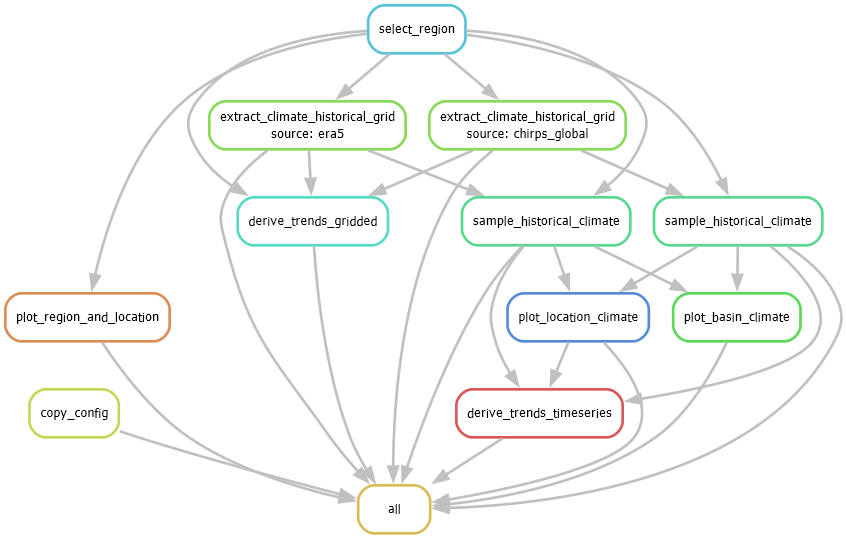

In [12]:
display.Image("./dag_historical_climate.png")

Let's have a closer look at this diagram, which shows the subsequent rules of the snakemake workflow:

TODO!
1. `create model`: the model is created for the region of interest (specified in *model_region* of the config file) at the chosen resolution (*model_resolution* in the config file). To build the model, the settings are described in *model_build_config*.   
2. `add_reservoirs_lakes_glaciers`: Reservoirs, lakes and glaciers (if any) are added to the model in a subsequent step, based on the settings described in *waterbodies_config*.
3. `add_gauges_and_outputs`: Gauges at the locations of (any available) observation stations are added to the model. These locations are used to directly save simulated discharge as scalar timeseries in a csv file. The location of the observation stations are provided in *output_locations* of the config file. The required outputs (state and flux variables) from the model that need to be saved from the simulation are also added to the model (*wflow_outvars* and *wflow_outvars_gridded*).
4. `setup_runtime`: the config file to prepare the forcing for the list of climate sources (*clim_historical*) and for the given historical period (*starttime*, *endtime*) are prepared. 
5. `add_forcing`: in this step, the gridded forcing file, including precipitation, potential evaporation and for each climate sources are written to netcdf file, which will be used to run the wflow model. 
6. `run_wflow`: the wflow model is then run with each climate source forcing file as input and all required output state and flux variables are saved.
7. `plot_map`: saves a map of the basin, elevation, gauges locations, reservoirs, lakes and glaciers.
8. `plot_forcing`: saves gridded maps of mean annual precipitation, temperature, potential evaporation for each of the climate sources. 
9. `plot_results`: saves a collection of figures to analyze the model performance. These figures are described in more detail in this notebook. 


Now we will unlock your directory in order to save the future results of the workflow. This step is most of the time not necessary.

In [13]:
! snakemake --unlock -s snakemake/Snakefile_climate_historical.smk --configfile config/my-project-settings.yml

Building DAG of jobs...
Unlocked working directory.


Snakemake also allows us to run a so-called *dryrun*, which will not actually run the workflow, but just print an overview of the rules that will be executed.

In [14]:
! snakemake all -c 1 -s snakemake/Snakefile_climate_historical.smk --configfile config/my-project-settings.yml --dryrun

Building DAG of jobs...
Job stats:
job                                count
-------------------------------  -------
all                                    1
copy_config                            1
derive_trends_gridded                  1
derive_trends_timeseries               1
extract_climate_historical_grid        2
plot_basin_climate                     1
plot_location_climate                  1
plot_region_and_location               1
sample_historical_climate              2
select_region                          1
total                                 12

Execute 2 jobs...

[Fri Sep 13 11:38:56 2024]
localrule copy_config:
    input: config/my-project-settings.yml
    output: examples/myModel/config/snake_config_climate_historical.yaml
    jobid: 1
    reason: Missing output files: examples/myModel/config/snake_config_climate_historical.yaml
    resources: tmpdir=<TBD>


[Fri Sep 13 11:38:56 2024]
localrule select_region:
    output: examples/myModel/region/region.geojson, examp

In the following, we will actually run the snakemake workflow for the historical hydrology:

In [15]:
%runrealcmd snakemake all -c 1 -s snakemake/Snakefile_climate_historical.smk --configfile config/my-project-settings.yml

c:\Users\bouaziz\AppData\Local\mambaforge\envs\blueearth-cst\Lib\subprocess.py:1016: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)


Assuming unrestricted shared filesystem usage.
Building DAG of jobs...
Provided cores: 1 (use --cores to define parallelism)
Rules claiming more threads will be scaled down.
Job stats:
job                                count
-------------------------------  -------
all                                    1
copy_config                            1
derive_trends_gridded                  1
derive_trends_timeseries               1
extract_climate_historical_grid        2
plot_basin_climate                     1
plot_location_climate                  1
plot_region_and_location               1
sample_historical_climate              2
select_region                          1
total                                 12

Select jobs to execute...
Execute 1 jobs...

[Fri Sep 13 11:39:03 2024]
localrule copy_config:
    input: config/my-project-settings.yml
    output: examples/myModel/config/snake_config_climate_historical.yaml
    jobid: 1
    reason: Missing output files: examples/myModel/config/

## Results

First check that snake did run everything.

The diagram will show dotted lines when a rule has already been performed. 

In [16]:
! snakemake -s snakemake/Snakefile_climate_historical.smk --configfile config/my-project-settings.yml  --dag | dot -Tpng > dag_historical_climate.png

Building DAG of jobs...


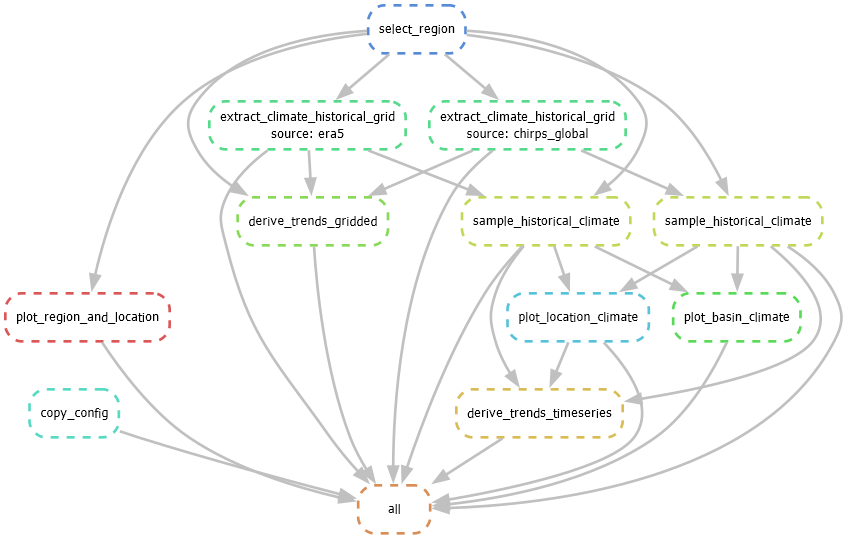

In [17]:
display.Image("./dag_historical_climate.png")

Let's see which files where created in our output folder.

In [18]:
root = "examples/myModel"
for path, _, files in os.walk(root):
    print(path)
    for name in files:
        if name.endswith(".xml"):
            continue
        print(f" - {name}")

examples/myModel
examples/myModel\climate_historical
examples/myModel\climate_historical\raw_data
 - extract_chirps_global.nc
 - extract_era5.nc
examples/myModel\climate_historical\statistics
 - basin_chirps_global.nc
 - basin_era5.nc
 - point_chirps_global.nc
 - point_era5.nc
 - point_observed.nc
examples/myModel\climate_historical\wflow_data
 - inmaps_historical_chirps_global.nc
 - inmaps_historical_era5.nc
examples/myModel\config
 - snake_config_climate_historical.yaml
 - snake_config_model_creation.yml
 - tests_data_catalog.yml
 - wflow_build_forcing_historical_chirps_global.yml
 - wflow_build_forcing_historical_era5.yml
 - wflow_build_model.yml
 - wflow_update_waterbodies.yml
examples/myModel\hydrology_model
 - hydromt.log
 - hydromt_data.yml
 - reservoir_accuracy.csv
 - reservoir_timeseries_jrc.csv
 - staticmaps.nc
 - wflow_sbm.toml
examples/myModel\hydrology_model\instate
examples/myModel\hydrology_model\run_default
 - hydromt.log
 - log.txt
 - output_chirps_global.csv
 - output

The region we have selected in this example notebook is the Piave, a small basin in Italy. The ECA climate dataset includes one station just outside the basin at SILLIAN. The location of the meteorological station, the elevation of the basin, the river network, the subregion (based on the upstream area of the location of a discharge station) are shown in the figure below. 

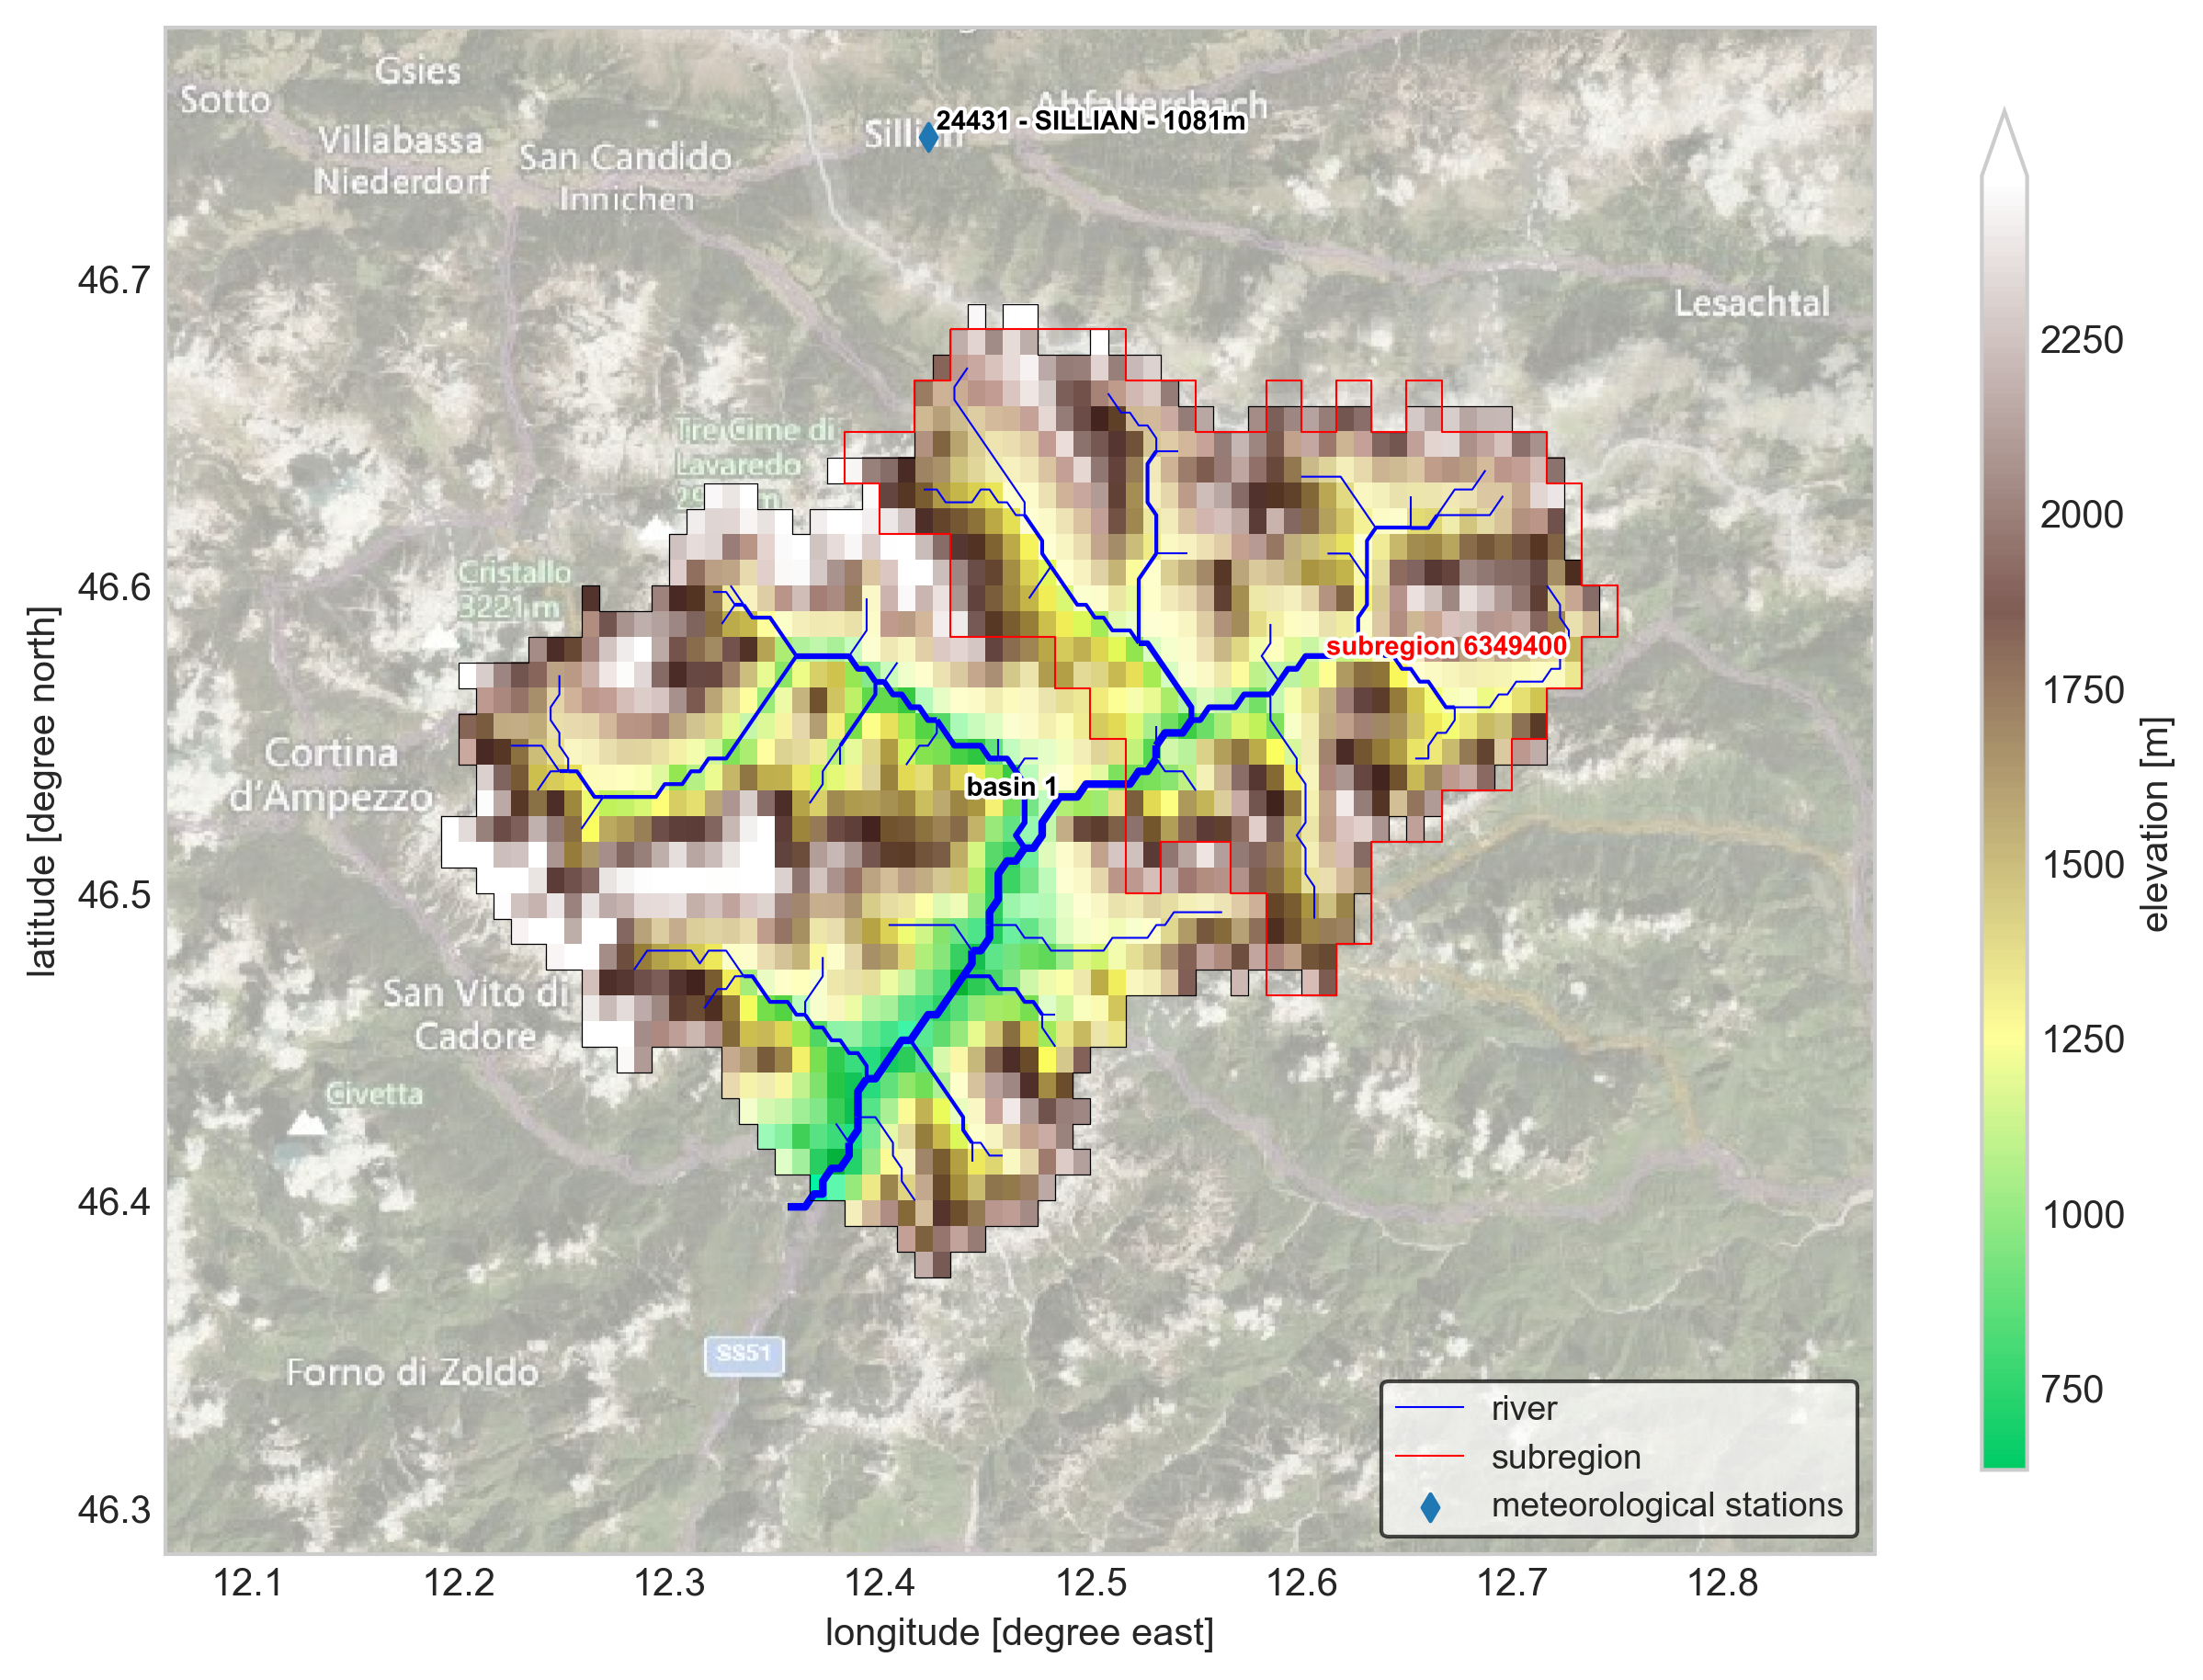

In [19]:
display.Image("./examples/myModel/plots/climate_historical/region_plot.png")

We first compare the spatial patterns of annual precipitation for the two selected climate sources (ERA5 and CHIRPS_global). As shown in the Figure below, there is a substantial difference between both datasets for the Piave basin. 

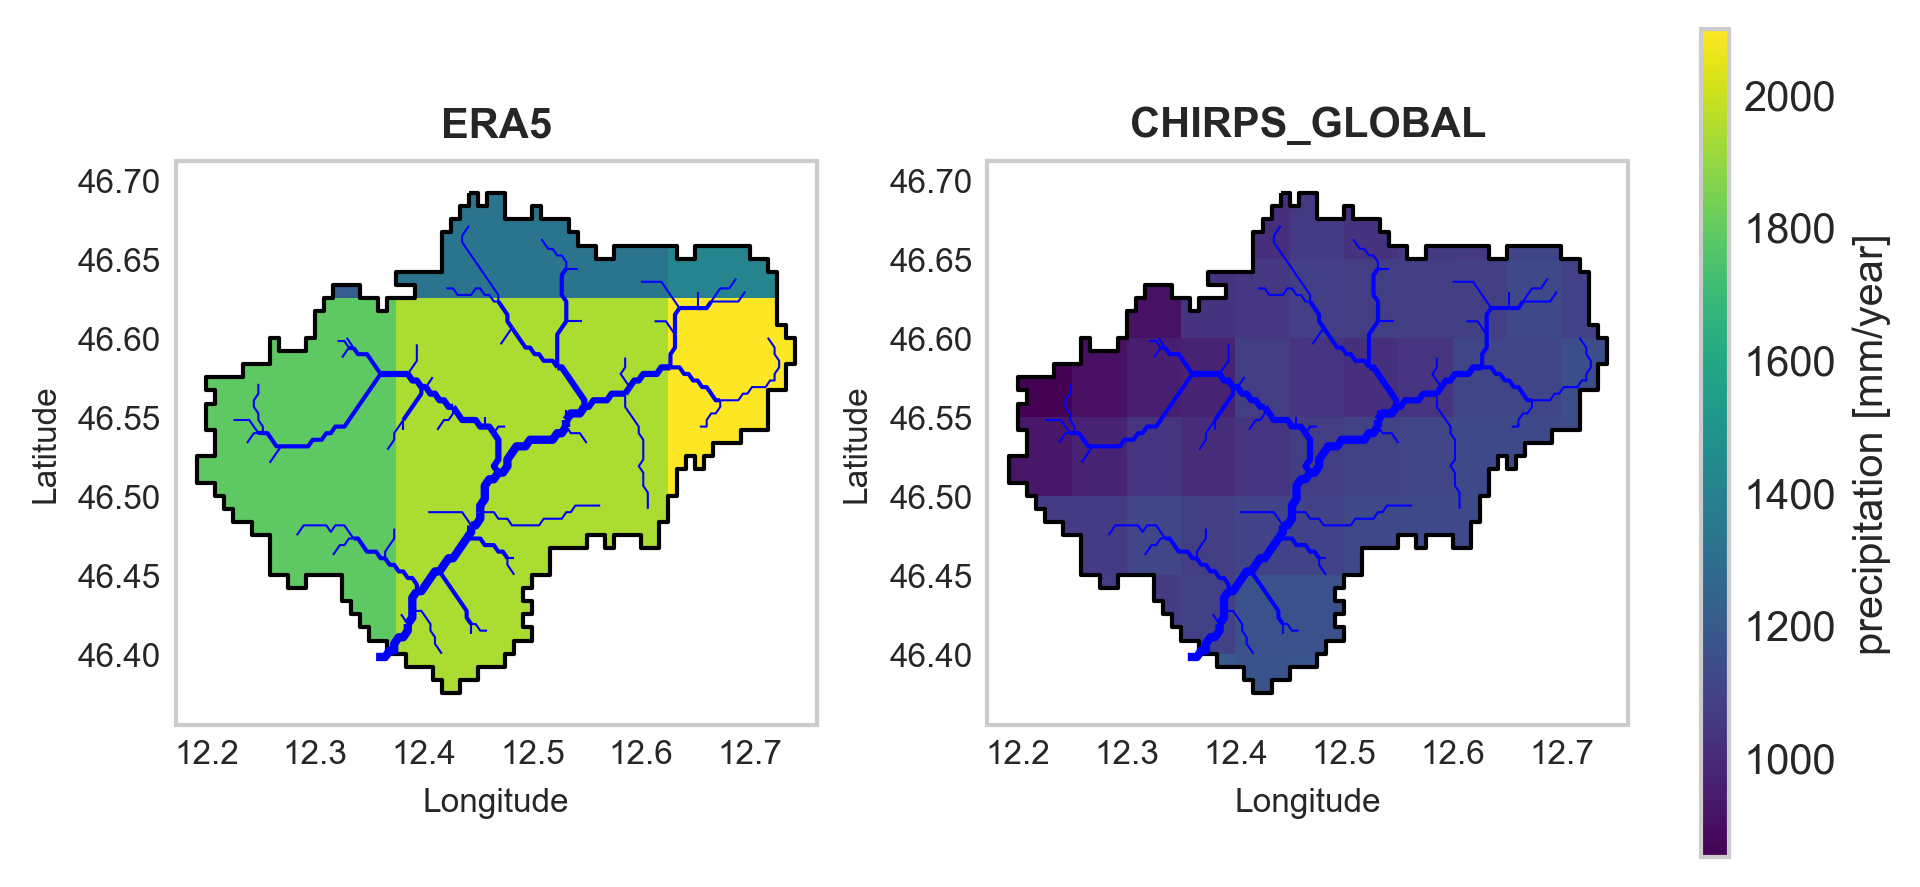

In [20]:
display.Image("./examples/myModel/plots/climate_historical/grid/mean_annual_precipitation.png")

In the next notebook on historical hydrology (todo add link!), we will see that these differences in precipitation lead to an overestimation of streamflow when using the ERA5 dataset as input, while streamflow is underestimated when CHIRPS_global dataset is used as input. 

Anomalies in annual precipitation rates, showing years with above normal or below normal precipitation, are shown in the Figure below. Similar figures are made in this workflow for each of the climate sources and also for temperature. 

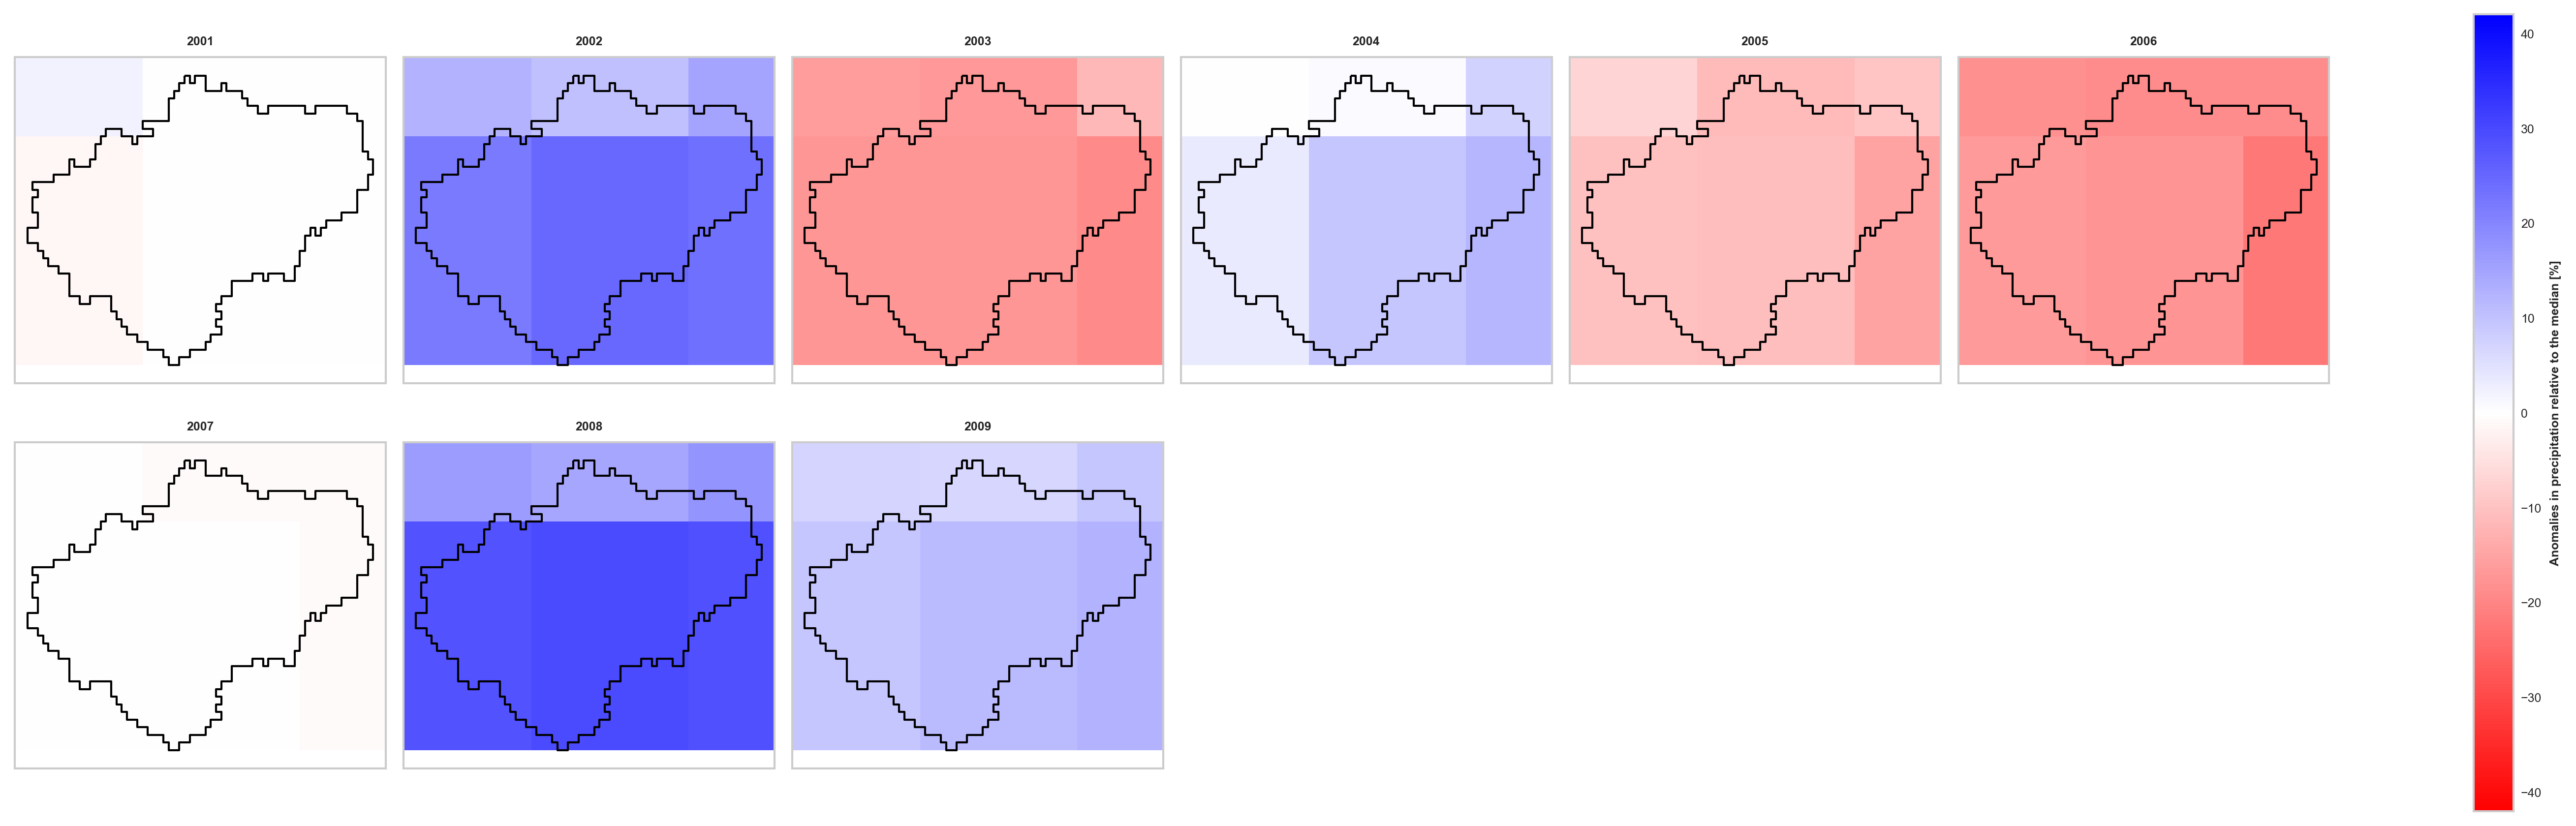

In [22]:
display.Image("./examples/myModel/plots/climate_historical/trends/gridded_anomalies_precip_era5.png")

Trends in precipitation at the locations of the climate stations for each of the climate sources are also plotted in this workflow. In the config file, it is possible to provide a year (*split_year*) to split the trend line in two periods. 

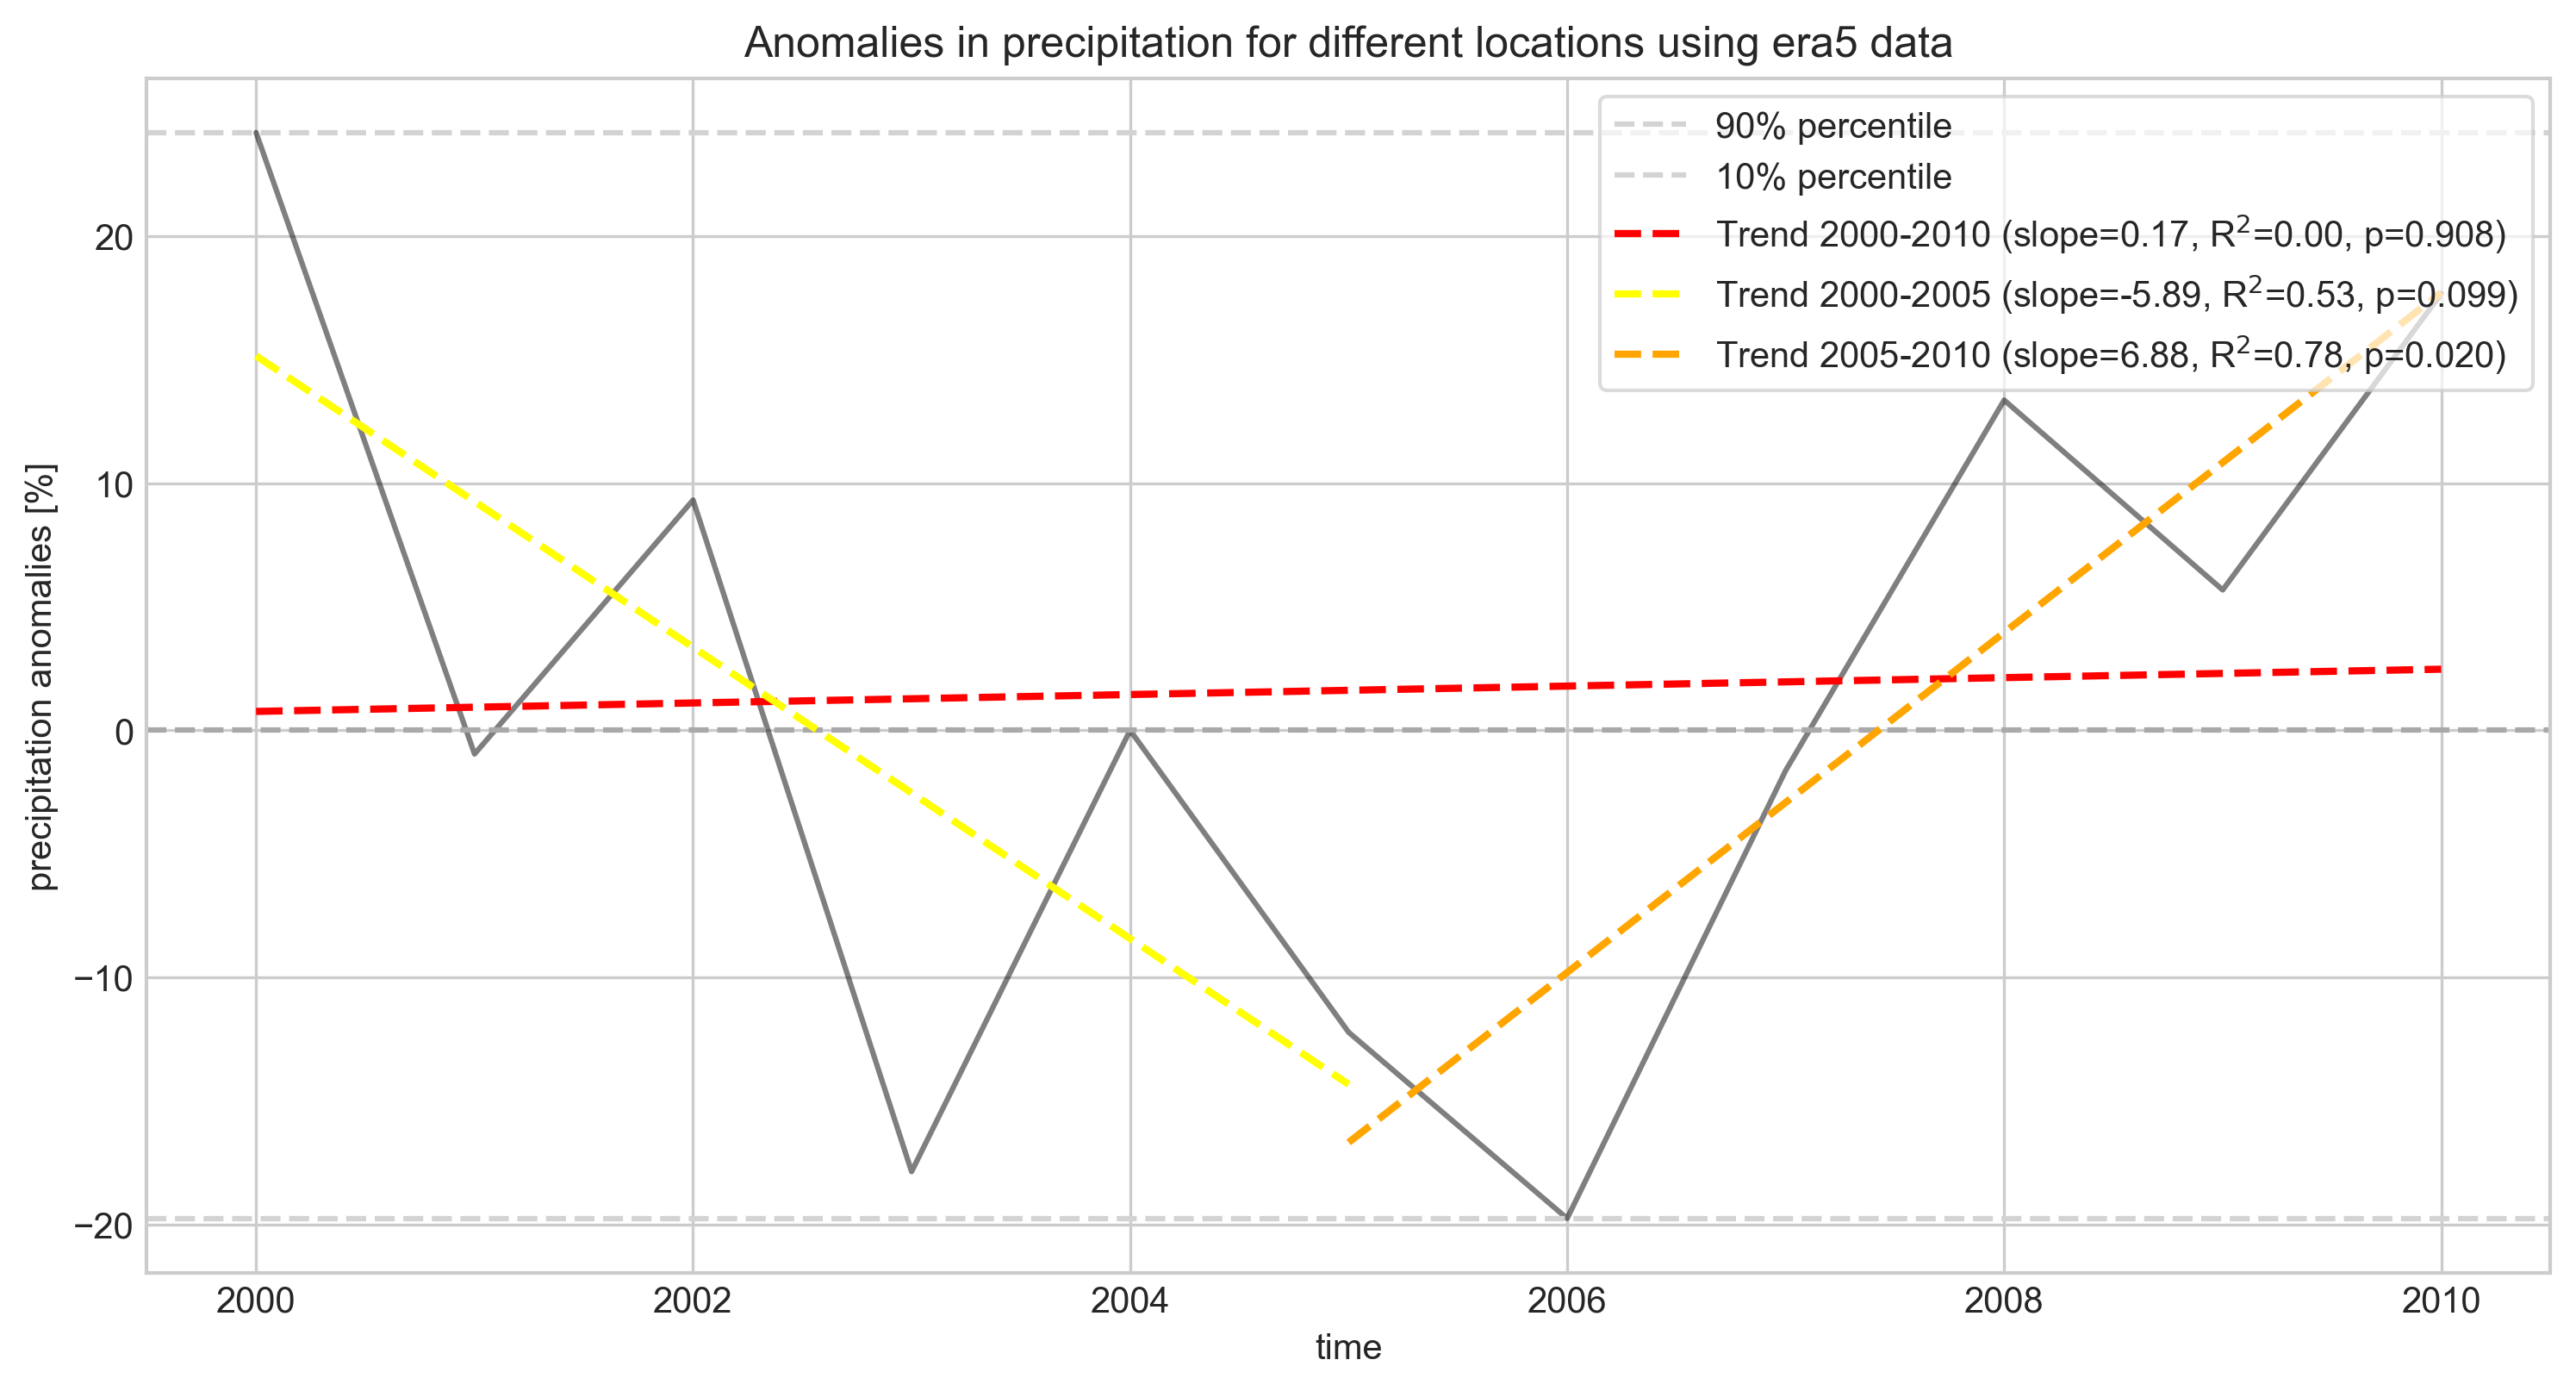

In [23]:
display.Image("./examples/myModel/plots/climate_historical/trends/timeseries_anomalies_precip_era5.png")

The workflow creates plots to show precipitation characteristics at the location of the stations and averaged over the subregions. Observed station data is added to these plots when available. 

For each subregion or location of a precipitation station and for each of the climate sources, the following plots are made:
- annual precipitation,
- cumulative precipitation,
- mean monthly precipitation,
- daily precipitation of the wettest year,
- daily precipitation of the driest year. 

This allows the user to evaluate precipitation volumes, dynamics and seasonality at various temporal scales between different climate sources. 


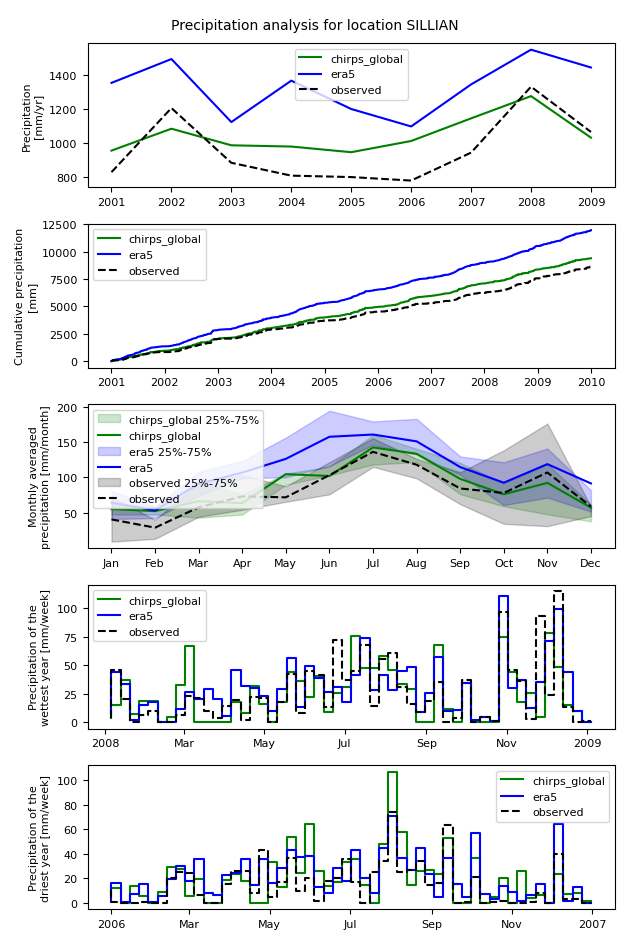

In [24]:
display.Image("./examples/myModel/plots/climate_historical/point/precipitation_SILLIAN.png")

In addition, plots are made of:
- the Standardized Precipitation Index (SPI)
- the number of events per year with precipitation higher than a defined threshold in the config file (*climate_thresholds.precip.peak*)
- the number of dry days per year (*climate_thresholds.precip.dry*)

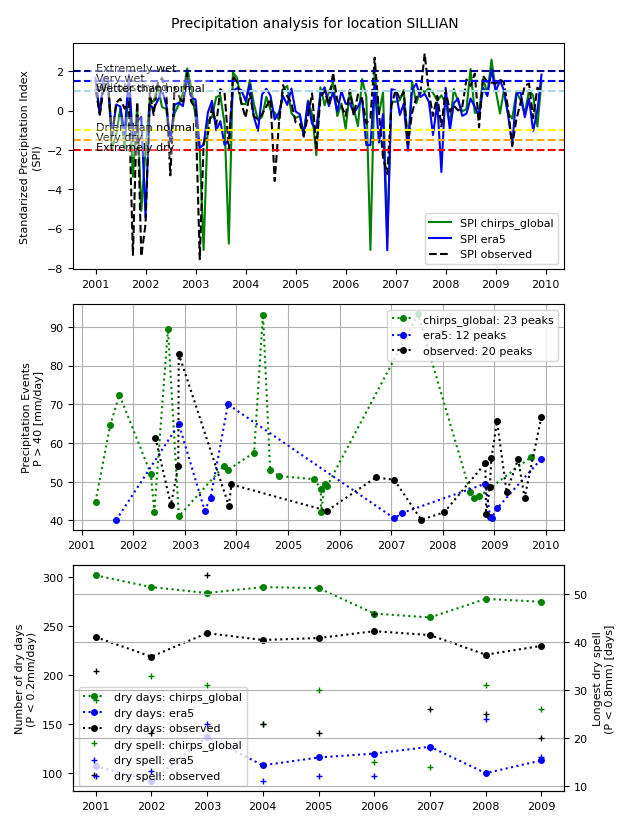

In [25]:
display.Image("./examples/myModel/plots/climate_historical/point/precipitation_extra_SILLIAN.png")

In the above example, we see.........

add boxplot

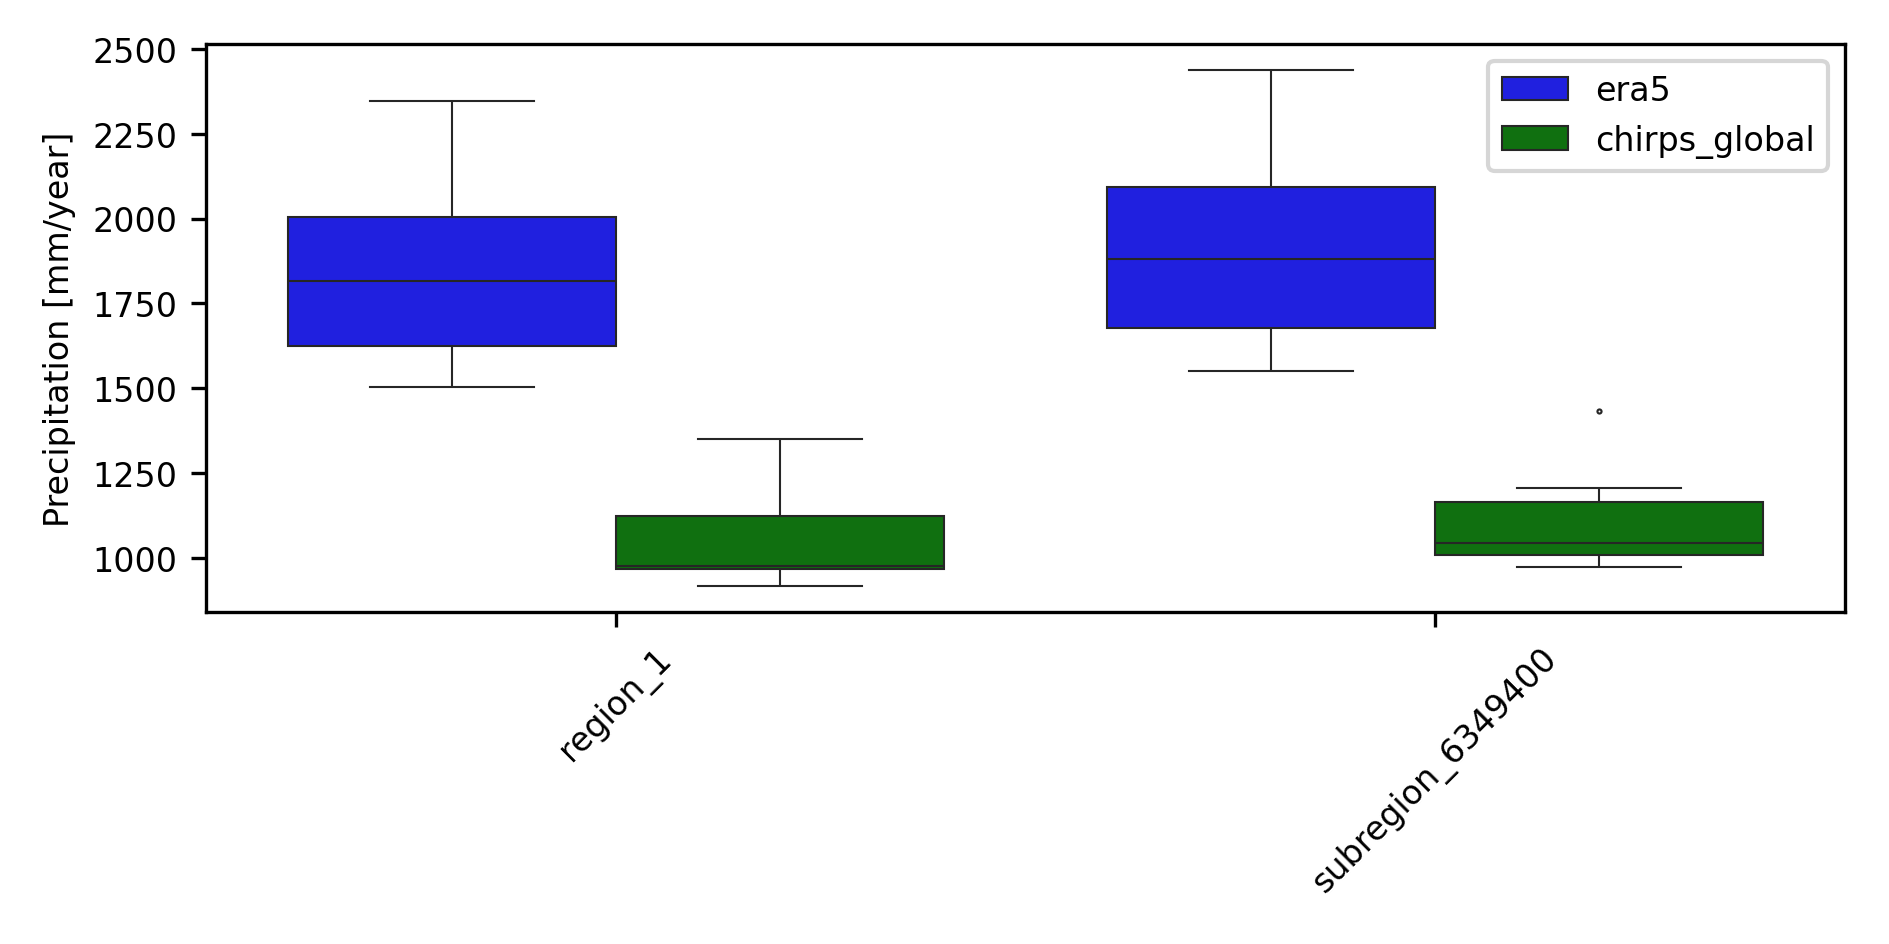

In [27]:
display.Image("./examples/myModel/plots/climate_historical/region/precipitation_boxplot.png")

Besides the precipitation analysis, we are also able to compare various sources of temperature data, as shown in the figure below. The following subplots are made for the evaluation of temperature data:
- time series of monthly temperature 
- mean monthly temperature regime 
- number of frost days 
- number of days with temperature above a certain threshold, which can be defined in the config file (*climate_thresholds.temp.heat*)

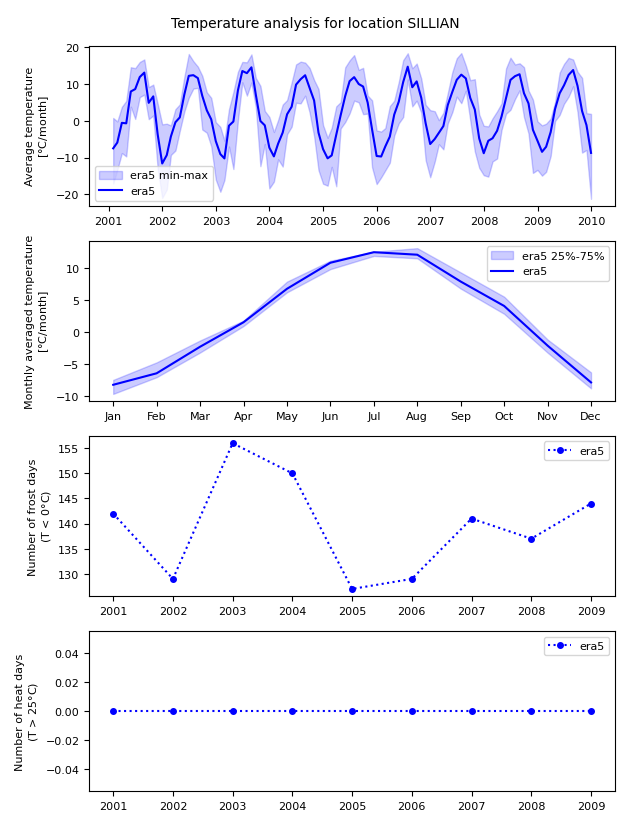

In [26]:
display.Image("./examples/myModel/plots/climate_historical/point/temperature_SILLIAN.png")